In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [4]:
def adjust_axes(axis_obj, x_label_fontsize, y_label_fontsize, x_label_rotation=0, y_label_rotation=0):
    for tick in axis_obj.xaxis.get_major_ticks():
        tick.label.set_fontsize(x_label_fontsize)
    for tick in axis_obj.yaxis.get_major_ticks():
        tick.label.set_fontsize(y_label_fontsize)
    for tick in axis_obj.xaxis.get_major_ticks():
        tick.label.set_rotation(x_label_rotation)
    for tick in axis_obj.yaxis.get_major_ticks():
        tick.label.set_rotation(y_label_rotation)        

In [5]:
data_dir = './jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [6]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [9]:
len(header)

15

In [8]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [50]:
lines[3]

'01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00'

In [7]:
lines[4]

'01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30'

In [10]:
len(lines[3].split(','))

15

In [51]:
lines[3].split(',')[1:]

['996.51',
 '-8.31',
 '265.12',
 '-9.07',
 '94.20',
 '3.26',
 '3.07',
 '0.19',
 '1.92',
 '3.08',
 '1309.19',
 '0.34',
 '0.50',
 '198.00']

In [12]:
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values    

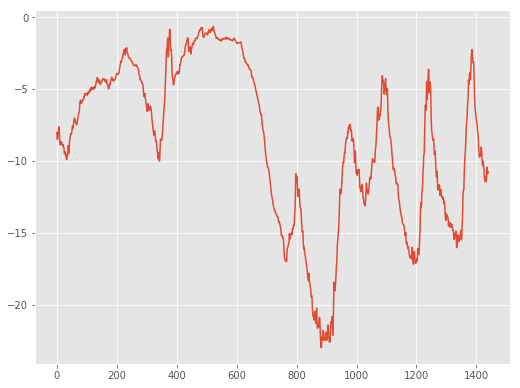

In [13]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8.5, 6.5))

temp = float_data[:, 1]
ax.plot(range(len(temp[:1440])), temp[:1440])


In [14]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [15]:
def generator(data, lookback, delay, min_index, max_index, shuffle, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        

In [16]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [17]:
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=False,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200000 + 1,
    max_index=300000,
    shuffle=False,
    step=step,
    batch_size=batch_size)


val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300000 + 1,
    max_index=None,
    shuffle=False,
    step=step,
    batch_size=batch_size)


In [22]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size 

In [23]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

mean_mae = evaluate_naive_method()


In [24]:
mean_mae

0.3097415575428445

In [60]:
mean_mae * std[1]

2.7419868538686605

In [31]:
def plot_history(history_object):
    FONTSIZE = 22
    plt.close('all')
    fig, ax = plt.subplots(1, figsize=(8.5, 6.5))

    epochs = range(1, len(history_object.history['loss']) + 1)
    train_loss = history_object.history['loss']
    val_loss = history_object.history['val_loss']

    ax.plot(epochs, train_loss, marker='o', label='training loss')
    ax.plot(epochs, val_loss, marker='x', label='validation loss')
    ax.set_xlabel('epoch', fontsize=FONTSIZE, labelpad=15)
    ax.set_ylabel('Loss', fontsize=FONTSIZE, labelpad=15)
    ax.set_xticks(np.arange(1, len(epochs)+1, 2))
    #ax.set_ylim(0, 2.0)
    adjust_axes(ax, FONTSIZE, FONTSIZE, 0, 0)
    ax.legend(loc='best', fontsize=FONTSIZE*0.85)
    ax.set_title('Loss fucntion', fontsize=FONTSIZE)    

### Feed-forward neural network

In [26]:
model = Sequential()
model.add(
    layers.Flatten(
        input_shape=(lookback // step, float_data.shape[-1])
    )
)

model.add(
    layers.Dense(
        32, 
        activation='relu'
    )
)

model.add(
    layers.Dense(1)
)

model.compile(optimizer=RMSprop(), loss='mae')


In [29]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=400,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps,
    verbose=False
)

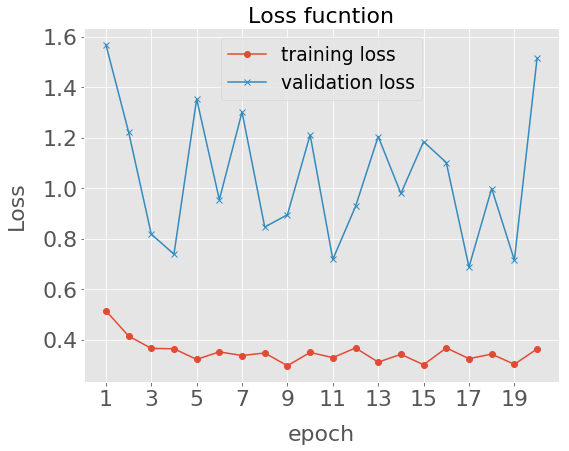

In [32]:
plot_history(history)

### GRU-based RNN with dropout

In [34]:
model = Sequential()

model.add(
    layers.GRU(
        32, 
        dropout=0.2,
        recurrent_dropout=0.2,
        input_shape=(None, float_data.shape[-1])
    )
)

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')


In [37]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=365,
    epochs=28,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/28
365/365 [==============================] - 376s 1s/step - loss: 0.3404 - val_loss: 0.4306
Epoch 2/28
365/365 [==============================] - 375s 1s/step - loss: 0.2889 - val_loss: 0.4209
Epoch 3/28
365/365 [==============================] - 376s 1s/step - loss: 0.3043 - val_loss: 0.3825
Epoch 4/28
365/365 [==============================] - 375s 1s/step - loss: 0.3234 - val_loss: 0.3392
Epoch 5/28
365/365 [==============================] - 374s 1s/step - loss: 0.3282 - val_loss: 0.3187
Epoch 6/28
365/365 [==============================] - 374s 1s/step - loss: 0.2898 - val_loss: 0.3519
Epoch 7/28
365/365 [==============================] - 374s 1s/step - loss: 0.3088 - val_loss: 0.3396
Epoch 8/28
365/365 [==============================] - 375s 1s/step - loss: 0.3066 - val_loss: 0.3112
Epoch 9/28
365/365 [==============================] - 375s 1s/step - loss: 0.3056 - val_loss: 0.4045
Epoch 10/28
365/365 [==============================] - 374s 1s/step - loss: 0.3098 - val_lo

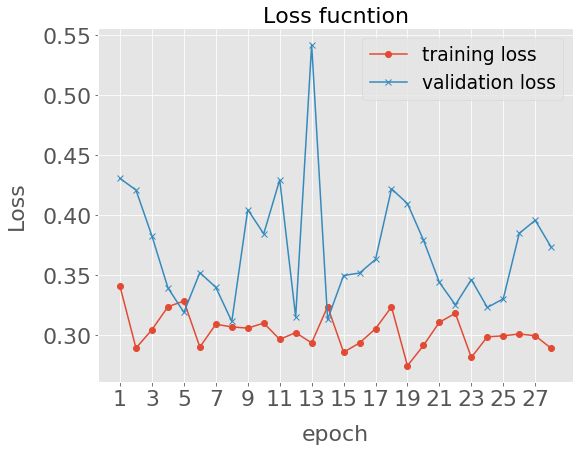

In [38]:
plot_history(history)

### Stacked GRU-based RNNs

In [40]:
model = Sequential()

model.add(
    layers.GRU(
        32,
        dropout=0.1,
        recurrent_dropout=0.5,
        return_sequences=True,
        input_shape=(None, float_data.shape[-1])
    )
)

model.add(
    layers.GRU(
        64, 
        dropout=0.1,
        recurrent_dropout=0.5,        
        activation='relu'        
    )
)

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')


In [41]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=365,
    epochs=28,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/28
365/365 [==============================] - 889s 2s/step - loss: 0.3411 - val_loss: 0.4614
Epoch 2/28
365/365 [==============================] - 924s 3s/step - loss: 0.3157 - val_loss: 0.5350
Epoch 3/28
365/365 [==============================] - 926s 3s/step - loss: 0.3241 - val_loss: 0.3855
Epoch 4/28
365/365 [==============================] - 923s 3s/step - loss: 0.2997 - val_loss: 0.4998
Epoch 5/28
365/365 [==============================] - 845s 2s/step - loss: 0.3071 - val_loss: 0.4569
Epoch 6/28
365/365 [==============================] - 844s 2s/step - loss: 0.3077 - val_loss: 0.4741
Epoch 7/28
365/365 [==============================] - 836s 2s/step - loss: 0.3199 - val_loss: 0.4700
Epoch 8/28
365/365 [==============================] - 836s 2s/step - loss: 0.2816 - val_loss: 0.5376
Epoch 9/28
365/365 [==============================] - 838s 2s/step - loss: 0.3012 - val_loss: 0.3871
Epoch 10/28
365/365 [==============================] - 873s 2s/step - loss: 0.3163 - val_lo

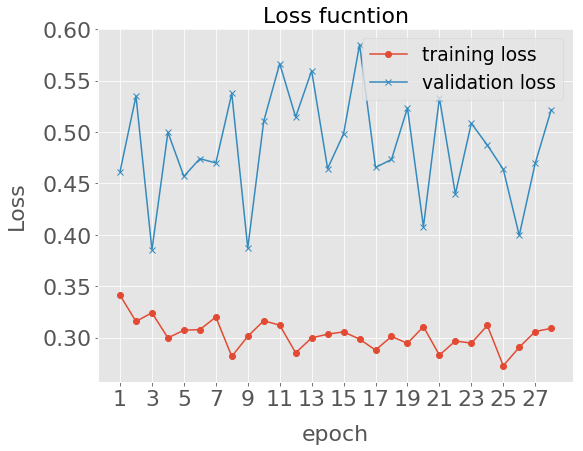

In [42]:
plot_history(history)

### 1D ConvNet + RNN

In [44]:
lookback = 1440
step = 3
delay = 144
batch_size = 128

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size 

In [45]:
train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=False,
    step=step,
    batch_size=batch_size)

val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200000 + 1,
    max_index=300000,
    shuffle=False,
    step=step,
    batch_size=batch_size)


val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300000 + 1,
    max_index=None,
    shuffle=False,
    step=step,
    batch_size=batch_size)

In [46]:
model = Sequential()

model.add(
    layers.Conv1D(
        filters=32,
        kernel_size=5,
        activation='relu',
        input_shape=(None, float_data.shape[-1])
    )
)

model.add(layers.MaxPooling1D(3))

model.add(layers.Conv1D(32, 5, activation='relu'))

model.add(
    layers.GRU(
        32, 
        dropout=0.1,
        recurrent_dropout=0.5
    )
)

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [47]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=400,
    epochs=30,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/30
400/400 [==============================] - 388s 970ms/step - loss: 0.3279 - val_loss: 1.1505
Epoch 2/30
400/400 [==============================] - 402s 1s/step - loss: 0.3146 - val_loss: 0.9160
Epoch 3/30
400/400 [==============================] - 392s 979ms/step - loss: 0.3353 - val_loss: 0.8579
Epoch 4/30
400/400 [==============================] - 396s 991ms/step - loss: 0.3281 - val_loss: 0.5390
Epoch 5/30
400/400 [==============================] - 389s 972ms/step - loss: 0.2874 - val_loss: 1.0857
Epoch 6/30
400/400 [==============================] - 391s 978ms/step - loss: 0.3070 - val_loss: 0.8421
Epoch 7/30
400/400 [==============================] - 393s 984ms/step - loss: 0.3053 - val_loss: 0.7830
Epoch 8/30
400/400 [==============================] - 423s 1s/step - loss: 0.3344 - val_loss: 0.5731
Epoch 9/30
400/400 [==============================] - 391s 978ms/step - loss: 0.2856 - val_loss: 0.6892
Epoch 10/30
400/400 [==============================] - 390s 975ms/step

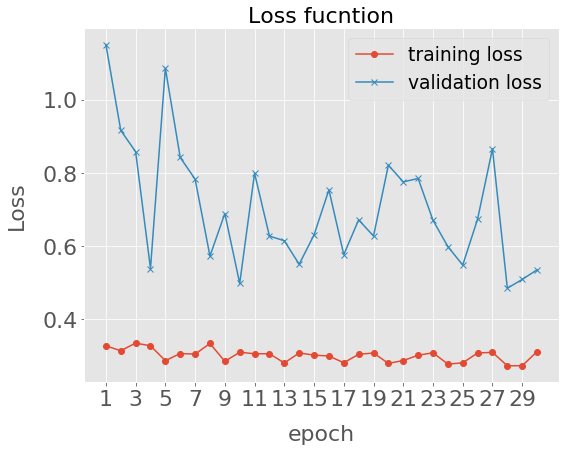

In [48]:
plot_history(history)